In [18]:
import os
import pickle

import cv2
import sophus as sp
import matplotlib.pyplot as plt

import fairotag as frt

In [19]:
MARKER_LENGTH = 0.04
NUM_CAMERAS = 3

NUM_SAMPLES = 8
DATA_DIR = "data/1_multi_camera_scene"

In [20]:
with open("data/realsense_intrinsics.pkl", 'rb') as f:
    intrinsics = pickle.load(f)

camera_modules = []
for _ in range(NUM_CAMERAS):
    c = frt.CameraModule()
    c.set_intrinsics(intrinsics)
    camera_modules.append(c)

In [21]:
for c in camera_modules:
    for m_id in range(17):
        c.register_marker_size(m_id, length=MARKER_LENGTH)

In [22]:
scene = frt.Scene()

camera_names = ["Master", "Sub1", "Sub2"]
for camera_name in camera_names:
    pose_in_frame = sp.SE3() if camera_name == "Master" else None
    scene.add_camera(camera_name, frame="world", pose_in_frame=pose_in_frame)

scene.add_frame("board")
for m_id in range(17):
    pose_in_frame = sp.SE3() if m_id == 0 else None
    scene.add_marker(m_id, frame="board", length=0.02625, pose_in_frame=pose_in_frame)

In [23]:
# Frames
frames = scene.get_frames()
print(f"Frames: {frames}")
print(f"Info of frame '{frames[0]}':\n {scene.get_frame_info(frames[0])}\n")

# Cameras
cameras = scene.get_cameras()
print(f"Cameras: {cameras}")
print(f"Info of camera '{cameras[0]}':\n {scene.get_camera_info(cameras[0])}\n")

# Markers
markers = scene.get_markers()
print(f"Markers: {markers}")
print(f"Info of marker '{markers[0]}':\n {scene.get_marker_info(markers[0])}\n")

Frames: ['world', 'board']
Info of frame 'world':
 {'name': 'world', 'pose': SE3([[1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 1, 0],
     [0, 0, 0, 1]]), 'markers': [], 'cameras': ['Master', 'Sub1', 'Sub2']}

Cameras: ['Master', 'Sub1', 'Sub2']
Info of camera 'Master':
 {'name': 'Master', 'frame': 'world', 'pose': SE3([[1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 1, 0],
     [0, 0, 0, 1]]), 'pose_in_frame': SE3([[1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 1, 0],
     [0, 0, 0, 1]]), 'is_anchor': True}

Markers: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Info of marker '0':
 {'id': 0, 'frame': 'board', 'pose': SE3([[1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 1, 0],
     [0, 0, 0, 1]]), 'pose_in_frame': SE3([[1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 1, 0],
     [0, 0, 0, 1]]), 'length': 0.02625, 'is_anchor': True, 'is_visible': False}



In [24]:
# Load snapshots & detect markers
snapshots = []
for i in range(NUM_SAMPLES):
    snapshot = {}
    for c, camera_name in zip(camera_modules, camera_names):
        imgfile = os.path.join(DATA_DIR, f"{camera_name}_{i}.jpg")
        img = cv2.imread(imgfile)
        detected_markers = c.detect_markers(img)
        snapshot[camera_name] = detected_markers
        
    snapshots.append(snapshot)
    
# Calibrate scene
scene.calibrate_extrinsics(snapshots)

In [25]:
cameras = scene.get_cameras()
print(f"Cameras: {cameras}")
print(f"Info of camera '{cameras[0]}':\n {scene.get_camera_info(cameras[0])}\n")

Cameras: ['Master', 'Sub1', 'Sub2']
Info of camera 'Master':
 {'name': 'Master', 'frame': 'world', 'pose': SE3([[    0.999999985014506,  0.000161384745204494, -6.26574177370106e-05,  3.87170138241834e-06],
     [-0.000161382766939069,     0.999999986479264,  3.15764973456008e-05, -2.36053127269422e-05],
     [ 6.26625128548147e-05, -3.15663850449677e-05,     0.999999997538486,  1.98860888973526e-06],
     [                    0,                     0,                     0,                     1]]), 'pose_in_frame': SE3([[1, 0, 0, 0],
     [0, 1, 0, 0],
     [0, 0, 1, 0],
     [0, 0, 0, 1]]), 'is_anchor': True}



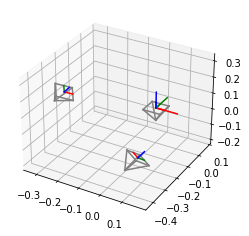

In [29]:
scene.visualize()